# CSCI-UA 0473 - Introduction to Machine Learning
## Wednesday, March 22, 2017

In [31]:
%matplotlib notebook 

import autograd.numpy as numpy
import autograd.numpy.random as npr

from autograd import grad

import scipy.optimize
import matplotlib.pyplot as plot

In [32]:
numpy.random.seed(1234)

## 1. Data Preparation

In [33]:
from sklearn.datasets import make_blobs

def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

n_dim = 2
x_tra, y_tra = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)
x_tes, y_tes = make_blobs(n_samples=100, n_features=n_dim, centers=[[1,1],[-1,-1],[1,-1],[-1,1]], shuffle=True, cluster_std=0.3)

y_tra = label_map(y_tra, [0, 1], 0)
y_tra = label_map(y_tra, [2, 3], 1)
y_tes = label_map(y_tes, [0, 1], 0)
y_tes = label_map(y_tes, [2, 3], 1)

## 2. Model Definition

In [34]:
def sigmoid(a):
    return 1. / (1. + numpy.exp(-a))

In [72]:
# Does everyone understand what is happening here?

def rbf(x, bases, width=1.):
    return numpy.exp(-(((x[:,None,:] - bases[None,:,:]) ** 2).sum(-1) / width))

# Different distance functions?

In [36]:
def logreg(x, w, pre=False):
    x = x.reshape([1, -1]) if len(x.shape) < 2 else x
    
    y = numpy.sum(x * w[None,:-1], axis=1) + w[-1]
    if pre:
        return y    
    return sigmoid(y)

In [37]:
def logreg_dist(y, x, w, avg=False):
    y_ = logreg(x, w)
    
    d = -(y * numpy.log(y_) + (1. - y) * numpy.log(1-y_))
    
    if not avg:
        return d
    return numpy.mean(d)

In [38]:
def cost(w, x, y):
    return logreg_dist(y, x, w, avg=True)

logreg_rule = grad(cost)

In [39]:
def _logreg_dist(w, x, y, avg=False):
    return logreg_dist(y, x, w, avg=avg), logreg_rule(w, x, y)

## 3. Modeling

In [40]:
n_bases = 10
# select random centroids
cids = npr.permutation(len(x_tra))[:n_bases]
all_centroids = x_tra[cids]

In [64]:
num_centroids = 10    # What happens when num_centroids = 1?
some_centroids = all_centroids[:num_centroids]
x_tra_ = rbf(x_tra, some_centroids, 1.)    # What is the dimension of x_tra_?

In [65]:
w0 = npr.randn(num_centroids + 1); w0[-1] = 0.
w = numpy.copy(w0)

res = scipy.optimize.minimize(_logreg_dist, w0, (x_tra_, y_tra, True), 
                              method='L-BFGS-B', jac=True, options={'maxls': 100})

In [66]:
print res
w = res.x

      fun: 1.3447475367561175e-05
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.35863679e-06,   2.39107855e-06,   3.07130359e-06,
         1.82162217e-06,   1.85099898e-06,   3.59098027e-06,
         4.57690762e-07,   5.07194241e-07,  -3.14965062e-07,
         4.03206864e-07,   6.97886174e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 17
   status: 0
  success: True
        x: array([-13.54587998, -10.81164276,  -9.99333951, -10.51255202,
       -10.86157073, -14.89286023,   7.65927712,   4.09195275,
        12.88541017,   4.81420727,   8.30537712])


## 4. Visualizing Decision Boundary

In [67]:
# visualize data 
def vis_data(x, y = None, c='r'):
    if y is None: 
        y = [None] * len(x)
    plot.hold('on')
    for x_, y_ in zip(x, y):
        if y_ is None:
            plot.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plot.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')
    plot.hold('off')
    plot.grid('on')

In [68]:
def vis_decision_boundary(w, typ='k--'):
    plot.hold('on')

    lim0 = plot.gca().get_xlim()
    lim1 = plot.gca().get_ylim()
    
    x_ = numpy.linspace(lim0[0], lim0[1], 100)
    y_ = numpy.linspace(lim1[0], lim1[1], 100)
    xx, yy = numpy.meshgrid(x_, y_)
    
    x_tra_ = rbf(numpy.concatenate([xx.ravel()[:,None], yy.ravel()[:,None]], axis=1), some_centroids, 1.)
    
    pred = logreg(x_tra_, w)
    plt1 = plot.contourf(xx, yy, pred.reshape(xx.shape), cmap=plot.cm.coolwarm, alpha=0.4)

    plot.gca().set_xlim(lim0)
    plot.gca().set_ylim(lim1)
    
    plot.hold('off')
    
    return plt1

<IPython.core.display.Javascript object>


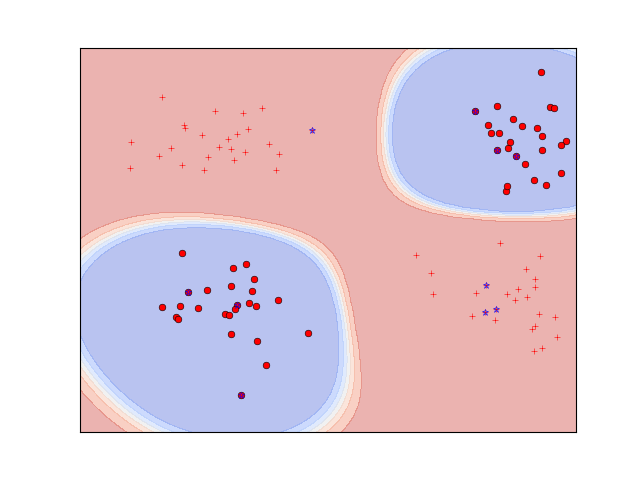

In [69]:
plot.figure()

vis_data(x_tra, y_tra, c='r')
vis_data(some_centroids, None, c='b')

plt1 = vis_decision_boundary(w, 'k--')

plot.show()

## 5. Testing

In [70]:
x_tra_ = rbf(x_tra, some_centroids, 1.)
x_tes_ = rbf(x_tes, some_centroids, 1.)

tra_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tra_, w)) - y_tra)) / numpy.float(len(y_tra))
tes_er = numpy.sum(numpy.abs(numpy.round(logreg(x_tes_, w)) - y_tes)) / numpy.float(len(y_tes))

print 'Training error rate {}, Test error rate {}'.format(tra_er, tes_er)

Training error rate 0.0, Test error rate 0.0
